# 3. Ensemble

## Import Libraries

In [3]:
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics
import h5py

## Load Dataset

In [4]:
"""Read data_set"""
f = h5py.File('DataSet_Pneumonia', 'r')

X_new = f['X_train']
X_train = X_new[::]
y_new = f['y_train']
y_train = y_new[::]

X_new = f['X_test']
X_test = X_new[::]
y_new = f['y_test']
y_test = y_new[::]

X_new = f['X_val_bla']
X_val_bal = X_new[::]
y_new = f['y_val_bal']
y_val_bal = y_new[::]

## Functions

In [34]:
def evaluate_model(y_score, y_pred):
    y_true = y_test
    print("Classification report: ")
    print(metrics.classification_report(y_true,y_pred,digits = 4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    # ROC curve
    fpr,tpr,th = metrics.roc_curve(y_true,y_score)
    roc_auc = metrics.roc_auc_score(y_true,y_score)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

## Load models
With the purpose of creating an ensemble model, we load the best performing models.

In [7]:
#import CNN model from scratch
from_scratch = tf.keras.models.load_model('/Users/marysia/Desktop/Deep_learning/models/pneumonia_models')
#import pre-trained VGG16 model
vgg_model = tf.keras.models.load_model('/Users/marysia/Desktop/Deep learning/pre_trained_model/pneumonia_models')

### Scores on test and validation sets

In [8]:
# vgg_model
vgg_test_scores = vgg_model.predict(X_test)
# from_scratch
from_scratch_test_scores = from_scratch.predict(X_test)

28/28 [==============================] - 14s 505ms/step


In [10]:
test_scores = [vgg_test_scores, from_scratch_test_scores]

In [11]:
# vgg_model
vgg_validation_scores = vgg_model.predict(X_val_bal)
# from_scratch
from_scratch_validation_scores = from_scratch.predict(X_val_bal)

15/15 [==============================] - 8s 554ms/step


In [13]:
val_scores = [vgg_validation_scores, from_scratch_validation_scores]

## Average Model
By averaging the predictions of multiple models, I take the average of the predictions made by each model on the same input data. The idea behind this approach is that the errors made by different models may cancel each other out, resulting in a final prediction that is more accurate than any single model's prediction.

In [14]:
ensemble_scores = []
n_models = len(test_scores)
for i in range(len(y_test)):
    ensemble_scores.append(np.sum([1/n_models*model_score[i] for model_score in test_scores]))

ensemble_predictions = np.rint(ensemble_scores)

Classification report: 
              precision    recall  f1-score   support

           0     0.9567    0.8894    0.9218       696
           1     0.9482    0.9805    0.9641      1437

    accuracy                         0.9508      2133
   macro avg     0.9525    0.9349    0.9429      2133
weighted avg     0.9510    0.9508    0.9503      2133



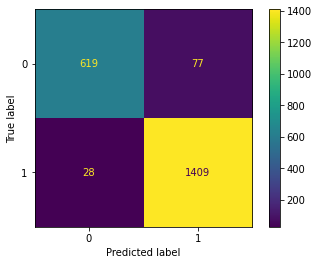

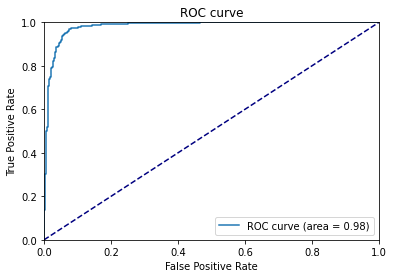

In [ ]:
evaluate_model(ensemble_scores, ensemble_predictions)

## Weighted Average Model
Combining the predictions of multiple models by assigning different weights to each model's prediction.

In [16]:
def weighted_average_scores(models_scores, weights):
    if len(weights) != len(models_scores):
        return
    weighted_scores = []
    for i in range(len(models_scores[0])):
        weighted_score = [weight*model_score[i] for weight,model_score in zip(weights, models_scores)]
        weighted_average = np.sum(weighted_score, axis = 0)
        weighted_scores.append(weighted_average)
    return weighted_scores

## Genetic Algorithm
This process can be computationally expensive and time-consuming, but it allows to find the best combination of models. With this technique, the genetic algorithm will search for a combination of models that performs better than any individual model.

- Termination is fitness function, which maximize the weighted F-measure on the validation set.
- Each chromosome is composed of two genes, which represent the weights associated with the two models.
- The parameters of the genetic algorithm such as initial population of candidate solutions, population size, number of generations, and crossover and mutation probabilities are chosen experimentally.


In [17]:
def f1_measure(weights):
    weighted_scores = weighted_average_scores(val_scores, weights)
    predictions = np.rint(weighted_scores)
    return metrics.f1_score(y_val_bal, predictions, average="weighted")

In [18]:
# tournament selection
def selection(population, scores, k=3):
    selection_indexes = [rn.randrange(0, len(population), 1) for i in range(k)]
    selected_index = selection_indexes[0]
    for i in selection_indexes[1:]:
        # perform the tournament, i.e. check if new selection is better than last one
        if scores[i] > scores[selected_index]:
              selected_index = i
    return population[selected_index]

In [19]:
# average crossover
def crossover(parent_1, parent_2, r_genes):
    children_1, children_2 = parent_1.copy(), parent_2.copy()
    random_genes_indexes = [rn.randrange(0, len(parent_1), 1) for i in range(r_genes)]
    for i in random_genes_indexes:
        average = (parent_1[i] + parent_2[i])/2
        children_1[i] = average
        children_2[i] = average
    return [[float(i)/sum(children_1) for i in children_1], 
          [float(i)/sum(children_2) for i in children_2]] # normalization is needed because the sum of weights must be one

In [20]:
# all-positions mutation
def mutation(chromosome):
    index = rn.randint(0, len(chromosome)-1)
    chromosome[index] = rn.random()
    return [float(i)/sum(chromosome) for i in chromosome]

In [21]:
# weighted f1-measure on validation set
def fitness(chromosome):
    return f1_measure(chromosome)

In [22]:
def genetic_algorithm(fitness, number_of_models, population_size, number_of_generations, p_crossover, p_mutation):
    population = [] #initial popoluation
    for i in range(population_size):
        chromosome = [rn.random() for _ in range(number_of_models)]
        chromosome = [float(i)/sum(chromosome) for i in chromosome]
        population.insert(i, chromosome)
    best_chromosome, best_fitness = 0, fitness(population[0]) #following the solutions
  
    for generation in range(number_of_generations):

        scores = [fitness(chromosome) for chromosome in population] # evaluate all candidates in the population
        # check new best solution
        new_best = False
        for i in range(population_size):
            if scores[i] > best_fitness:
                new_best = True
                best_chromosome, best_fitness = population[i], scores[i]
        if new_best:
            print(f">Generation {generation+1}, new best = {best_chromosom} = {best_fitness})

        selected = [selection(population, scores) for _ in range(population_size)] # select parents
        children = []     # next generation

    for i in range(0, population_size, 2):
        p1, p2 = selected[i], selected[i+1] ## join selected parents in pairs
        #crossover and mutation
        if rn.random() < p_crossover:
            for c in crossover(p1, p2, r_genes=2):
                if rn.random() < p_mutation:
                    mutation(c)
                children.append(c) # store for next generation
        else:
            children.append(p1)
            children.append(p2)
            
    population = children #new population
    return [best_chromosome, best_fitness]

In [23]:
weights = None
fmeasure = -10
for i in range(10):
    print("Iteration ", i)
    cw, cfm = genetic_algorithm(fitness, 2, 100, 100, 0.4, 0.005)
    if cfm > fmeasure:
        fmeasure = cfm
        weights = cw
    print("------------")

Iteration  0
>Generation 1, new best f([0.43409155739509936, 0.5659084426049006]) = 0.9874
>Generation 66, new best f([0.08713733601331286, 0.5711268723454607]) = 0.9874
------------
Iteration  1
>Generation 1, new best f([0.43935931604127376, 0.5606406839587262]) = 0.9874
>Generation 20, new best f([0.15634926995894727, 0.5752355914670528]) = 0.9874
------------
Iteration  2
>Generation 1, new best f([0.41682441171567614, 0.583175588284324]) = 0.9874
>Generation 8, new best f([0.11012762227824369, 0.5813263171043215]) = 0.9874
------------
Iteration  3
>Generation 1, new best f([0.4174286314226268, 0.5825713685773731]) = 0.9874
>Generation 54, new best f([0.06505208289683384, 0.5737424265560149]) = 0.9874
------------
Iteration  4
>Generation 1, new best f([0.4404068775308588, 0.5595931224691412]) = 0.9874
>Generation 13, new best f([0.11333059386816169, 0.5673525009693308]) = 0.9874
------------
Iteration  5
>Generation 1, new best f([0.4167234344597301, 0.5832765655402699]) = 0.9874

In [24]:
print(weights)
print(fmeasure)

[0.08713733601331286, 0.5711268723454607]
0.9873949579831933


Classification report: 
              precision    recall  f1-score   support

           0     0.9657    0.9825    0.9740       229
           1     0.9938    0.9877    0.9907       650

    accuracy                         0.9863       879
   macro avg     0.9797    0.9851    0.9824       879
weighted avg     0.9865    0.9863    0.9864       879



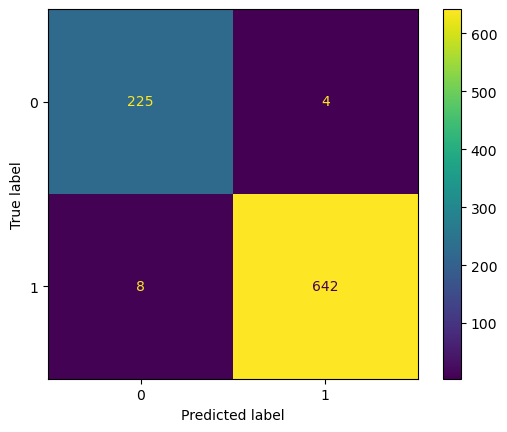

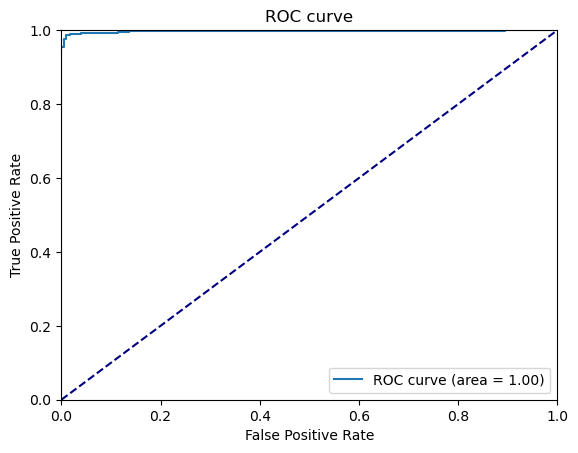

In [35]:
ensemble_scores = weighted_average_scores(test_scores, weights)
ensemble_predictions = np.rint(ensemble_scores)
evaluate_model(ensemble_scores, ensemble_predictions)